<a href="https://colab.research.google.com/github/pollinations/hive/blob/main/notebooks/1%20Text-To-Image/1%20LAION%20Latent%20Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://cloudflare-ipfs.com/ipfs/QmZwyfox3JsR34F3e82pPbrbBhKPFrUEsXuBFuKJfiiHxp?filename=abstract-geometric-chihuahua-.png" width="300" height="300" />

Example: *Abstract geometric Chihuahua*

Latent Diffusion model Text-to-image synthesis with 1.45B parameter model. This great model rivals OpenAI's DALL-E and can generate beautiful artistic styles as well as faces and text.

**Should work with the free mode of Google Colab now**

---
Credits: model released by [CompVis](https://github.com/CompVis/latent-diffusion) and trained on the [LAION-400M dataset](https://laion.ai/laion-400-open-dataset/)
Colab assembled by [@multimodalart](https://twitter.com/multimodalart)

In [1]:
Prompt = "Abstract geometric Chihuahua" #@param{type:"string"}

Steps = 100 #@param {type:"integer"}

# Apparently this parameter can be 0 or 1. Did not completely understand what it does yet.
ETA = 1 #@param{type:"integer"}

Iterations = 1 
#@param{type:"integer"}

# How many images to generate in parallel.
Samples_in_parallel=2 #@param{type:"integer"}

# As a rule of thumb, higher values of scale produce better samples at the cost of a reduced output diversity.
Diversity_scale=10.0 #@param {type:"number"}

PLMS_sampling=True #@param {type:"boolean"}

output_path = "/content"

In [2]:
# Rename to hide the poorly working interpolation function
Prompts = Prompt

# Up to 512x512 should be possible without running out of memory

Width=256

# Up to 512x512 should be possible without running out of memory
Height=256

# Setup stuff

In [3]:
#@title Installation
!sudo apt install -y aria2
!git clone https://github.com/crowsonkb/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
!pip install open_clip_torch
!pip install autokeras
!pip install tensorflow

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

import os
os.makedirs(output_path, exist_ok=True)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aria2 is already the newest version (1.33.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Obtaining file:///content/taming-transformers
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Can't uninstall 'taming-transformers'. No files were found to uninstall.
  Running setup.py develop for taming-transformers


Now, download the checkpoint (~5.7 GB). This will usually take 3-6 minutes.

In [4]:
#@title Download model
%cd latent-diffusion/ 


!mkdir -p /content/models/
if not os.path.exists("/content/models/ldm-model.ckpt"):
  !wget -O /content/models/ldm-model.ckpt https://ipfs.pollinations.ai/ipfs/QmUKTHwT9nWtPp1bes3VGjQRk8gizKvTo6s4cNgsoM1Jpk/model.ckpt

/content/latent-diffusion


Let's also check what type of GPU we've got.

In [5]:
!nvidia-smi

Sun May 22 22:36:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load it.

In [6]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

In [7]:
#@title Import stuff
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from open_clip import tokenizer
import open_clip


In [8]:
# pomp@title Load necessary functions

#NSFW CLIP Filter
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().cuda()
    model.eval()
    return model

config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml") 
model = load_model_from_config(config, "/content/models/ldm-model.ckpt") 

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)



Loading model from /content/models/ldm-model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [34]:
frame_id = 0
def save_img_callback(pred_x0, i):
  global frame_id
  # print(pred_x0)
  x_samples_ddim = model.decode_first_stage(pred_x0)
  imgs = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
  imgs = 255. * rearrange(imgs.cpu().numpy(), 'b c h w -> h (b w) c')
  Image.fromarray(imgs.astype(np.uint8)).save(f"{output_path}/aaa_{frame_id:04}.png")
  frame_id += 1



def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))

    all_samples=list()
    samples_ddim, x_samples_ddim = None, None
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for prompt in opt.prompts:
                    print(prompt)
                    for n in range(opt.n_iter):
                        c = model.get_learned_conditioning(opt.n_samples * [prompt])
                        shape = [4, opt.H//8, opt.W//8]
                        samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                        conditioning=c,
                                                        batch_size=opt.n_samples,
                                                        shape=shape,
                                                        verbose=False,
                                                        img_callback=save_img_callback,
                                                        unconditional_guidance_scale=opt.scale,
                                                        unconditional_conditioning=uc,
                                                        eta=opt.ddim_eta,
                                                        x_T=samples_ddim)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                        # for x_sample in x_samples_ddim:
                        #     x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        #     Image.fromarray(x_sample.astype(np.uint8)).save(os.path.join(output_path, f"aaa_{base_count:04}-{n}.png"))
                        #     base_count += 1
                        all_samples.append(x_samples_ddim)


        # additionally, save as grid
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=opt.n_samples)

        # to image
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        
        Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'zzz_{prompt.replace(" ", "-")}.png'))
        display(Image.fromarray(grid.astype(np.uint8)))
        #print(f"Your samples are ready and waiting four you here: \n{outpath} \nEnjoy.")

# Do the run

Abstract geometric Chihuahua
Data shape for PLMS sampling is (2, 4, 32, 32)
Running PLMS Sampling with 100 timesteps


PLMS Sampler: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


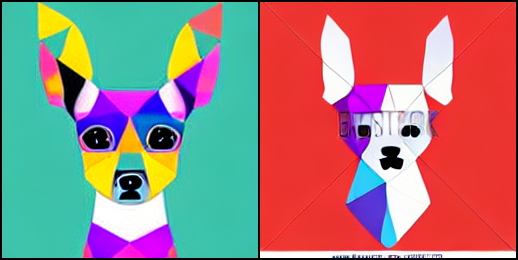

In [35]:
#@title Parameters
import argparse


!rm {output_path}/aaa_*.png

args = argparse.Namespace(
    prompts = Prompts.split("->"), 
    outdir=output_path,
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling
)
run(args)

In [36]:
!ffmpeg -y -r 10 -i {output_path}/aaa_%04d.png {output_path}/zzzzzzzzzzzz_output.mp4


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib